# Monoallelic Dataset Benchmark Evaluation

### Libraries

In [1]:
#analysis
import numpy as np
import pandas as pd
from io import StringIO
#plotting
import matplotlib.pyplot as plt
from matplotlib import cm
#logging
from typing import Union
import logging
logging.basicConfig(level=logging.DEBUG)
#enable logging debug
logging.disable(logging.DEBUG)

### Parameters

In [2]:
PATH_TO_RESULT_DICT = 'run/allele_specific_wgibbs_run.txt'

#for evaluation
TOP_i = [2]

#for plotting of taking more than the 2 best alleles from each locus
TOP_i = [2,3,4,5,6]

#SWITCH: ONLY_2DIGIT_EVALUATION
#True -> only the 2-digit evaluation is performed
#False ->  -> default: the 4-digit evaluation is performed
ONLY_2DIGIT_EVALUATION = True

### Load result dict from monoallelic dataset run

In [3]:
result_dict = {}
with open(PATH_TO_RESULT_DICT,'r') as f:
    result_dict = eval(f.read())
print(result_dict)

{'04-001': {'overall peptides in tuedb': 1610, 'peptide not in monoallelic ds': 1241, 'peptides': {'donor allele': {'A0101': 150, 'A2402': 113, 'B0801': 15, 'B1402': 74, 'C0701': 0, 'C0802': 1}, 'not donor allele': {'A2301': 5, 'A2902': 1, 'A6802': 1, 'C1402': 1, 'B2705': 3, 'A0207': 1, 'A2501': 1, 'A0201': 1, 'C0401': 1, 'B5703': 1}}}, '1003': {'overall peptides in tuedb': 2018, 'peptide not in monoallelic ds': 1564, 'peptides': {'donor allele': {'A0101': 125, 'A0201': 74, 'B5101': 180, 'B5701': 47, 'C0401': 5, 'C0602': 7}, 'not donor allele': {'C0303': 1, 'B5801': 3, 'A0207': 1, 'C0501': 1, 'B1501': 1, 'B2705': 1, 'C1505': 2, 'A6901': 1, 'A3201': 2, 'A2402': 1, 'A0205': 2}}}, '1008': {'overall peptides in tuedb': 1484, 'peptide not in monoallelic ds': 1189, 'peptides': {'donor allele': {'A0101': 97, 'A0201': 56, 'B0801': 36, 'B4001': 101, 'C0304': 0, 'C0701': 0}, 'not donor allele': {'C0303': 1, 'B1801': 1, 'B1501': 2, 'B4002': 1}}}, '1010': {'overall peptides in tuedb': 1866, 'pepti

### Functions

In [4]:
def generate_matching_counts(TOP_i: list) -> dict:
    matching_counts = {i: {'all': [], 'count_match_6': [], 'count_match_56': [], 'count_match_456': []} for i in TOP_i}
    return matching_counts

def generate_plot_dict(TOP_i: list) -> dict:
    plot = {i: {} for i in TOP_i}
    return plot

def make_dict_2digit(dict: dict) -> dict:
    new_dict = {}
    for key in dict:
        #add to it if it already exists
        if key[:3] in new_dict:
            new_dict[key[:3]] += dict[key]
        else:
            new_dict[key[:3]] = dict[key]
    return new_dict


def get_prediction_from_result_dict(combined_dict: dict, i: int) -> list:
    dict_a = {k: v for k, v in combined_dict.items() if k.startswith('A')}
    dict_a = sorted(dict_a.items(), key=lambda item: item[1], reverse=True)
    dict_b = {k: v for k, v in combined_dict.items() if k.startswith('B')}
    dict_b = sorted(dict_b.items(), key=lambda item: item[1], reverse=True)
    dict_c = {k: v for k, v in combined_dict.items() if k.startswith('C')}
    dict_c = sorted(dict_c.items(), key=lambda item: item[1], reverse=True)
    
    prediction = [key for key,_ in dict_a[:i]] + [key for key,_ in dict_b[:i]] + [key for key,_ in dict_c[:i]]

    return prediction

def evaluate_result_dict(donor: str, peptides_donor: dict, plot: dict, i: int) -> (Union[float,str], dict):

    if len(peptides_donor) < 4:
        logging.debug(f'The donor has 3 alleles (len(peptides_donor)<4), because donor has: {list(peptides_donor)}')
        return 'count_only_3_alleles',plot

    if len(peptides_donor) > 6:
        logging.debug(f'The donor has more than 6 alleles (len(peptides_donor)>6), because donor has: {list(peptides_donor)}')
        return 'count_more_than_6_alleles',plot
    
    logging.debug(f'There are {len(list(peptides_donor.keys()))} alleles for donor {donor}: {list(peptides_donor.keys())}')

    peptides_not_donor = result_dict[donor]['peptides']['not donor allele']
    
    if ONLY_2DIGIT_EVALUATION:
        peptides_not_donor = make_dict_2digit(peptides_not_donor)

    print_dict = {k: v for k, v in sorted(peptides_donor.items(), key=lambda item: item[1], reverse=True)}
    logging.debug(f'The counts of the peptides for donor alleles are: {print_dict}')
    print_dict_2 = {k: v for k, v in sorted(peptides_not_donor.items(), key=lambda item: item[1], reverse=True)}
    logging.debug(f'The counts of the peptides for non-donor alleles are: {print_dict_2}')
    
    combined_dict = {**peptides_donor, **peptides_not_donor}

    prediction = get_prediction_from_result_dict(combined_dict, i)
    

    if prediction == 'count_too_little_to_maj':
        return 'count_too_little_to_maj',plot
    
    list_donor_alleles = list(peptides_donor.keys())
    
    matching_count = 0
    for donor_allele in list_donor_alleles:
        if donor_allele in prediction:
            matching_count += 1

    logging.debug(f'Number of peptides that are matching: {matching_count} out of {len(list_donor_alleles)} donor alleles.')
    logging.debug(f'Number of peptides that are not matching: {(len(list_donor_alleles)-matching_count)} out of {len(list_donor_alleles)} donor alleles.')
    
    perc_matching = matching_count/len(list_donor_alleles)

    plot[i][donor] = {}
    plot[i][donor]['matching'] = (matching_count,len(list_donor_alleles))
    plot[i][donor]['pred and real alleles'] = [prediction,list_donor_alleles]

    return perc_matching, plot

### Main

In [5]:
matching_counts = generate_matching_counts(TOP_i)

plot = generate_plot_dict(TOP_i)

count_only_3_alleles = []
count_over_6 = []
count_too_little_to_maj = []
count_tuedb_and_monoallelic = []

print(f'There are {len(list(result_dict.keys()))} donors in total.')

for i in TOP_i:

    for donor in result_dict:
        logging.debug(f'\nDonor: {donor}')

        #get data from result dict
        overall_peptides = result_dict[donor]['overall peptides in tuedb']
        not_in_mono = result_dict[donor]['peptide not in monoallelic ds']
        logging.debug(f'Overall peptides in tuedb for donor {donor}: {overall_peptides}')
        logging.debug(f'Overall peptides in tuedb that are also in monoallelic ds for donor {donor}: {overall_peptides - not_in_mono}')
        count_in_mono = (overall_peptides - not_in_mono)/overall_peptides
        logging.debug(f'Percent of tuedb peptides that are also in monoallelic dataset for donor {donor}: {round(count_in_mono*100,2)} %')
        
        peptides_donor = result_dict[donor]['peptides']['donor allele']
        if ONLY_2DIGIT_EVALUATION:
            peptides_donor = make_dict_2digit(peptides_donor)

        perc_matching, plot = evaluate_result_dict(donor, peptides_donor, plot, i)

        if perc_matching == 'count_only_3_alleles':
            count_only_3_alleles.append(donor)
        elif perc_matching == 'count_more_than_6_alleles':
            count_over_6.append(donor)
        else:
            if perc_matching == 'count_too_little_to_maj':
                count_too_little_to_maj.append(donor)
                perc_matching = 0
            else:
                count_tuedb_and_monoallelic.append(count_in_mono*100)
                plot[i][donor]['tdb and mono'] = overall_peptides - not_in_mono
                plot[i][donor]['how good'] = perc_matching

            if len(peptides_donor) == 6:
                matching_counts[i]['count_match_6'].append(perc_matching)
                matching_counts[i]['count_match_56'].append(perc_matching)
                matching_counts[i]['count_match_456'].append(perc_matching)
            if len(peptides_donor) == 5:
                matching_counts[i]['count_match_56'].append(perc_matching)
                matching_counts[i]['count_match_456'].append(perc_matching)
            if len(peptides_donor) == 4:
                matching_counts[i]['count_match_456'].append(perc_matching)

    logging.debug(f"There are {len(count_only_3_alleles)} donors that have only 3 alleles. They get thrown out.\ncount_only_3_alleles: {count_only_3_alleles} (with {len(count_only_3_alleles)} elements)\nThere are {len(count_over_6)} donors that have more than 6 alleles. They get thrown out.\ncount_over_6: {count_over_6} (with {len(count_over_6)} elements)\nThere are {len(count_too_little_to_maj)} donors that have less than 2 votes to majority vote for for at least one of the loci.\ncount_too_little_to_maj: {count_too_little_to_maj} (with {len(count_too_little_to_maj)} elements)")
    logging.debug(f"On average {round(np.sum(matching_counts[i]['count_match_6'])/len(matching_counts[i]['count_match_6']),3)*100} % of the donor alleles are matching for donors with 6 alleles.\nOn average {round(np.sum(matching_counts[i]['count_match_56'])/len(matching_counts[i]['count_match_56']),3)*100} % of the donor alleles are matching for donors with 5 or 6 alleles.")
    if i == 2:
        print(f"On average {int(round(np.sum(matching_counts[i]['count_match_456'])/len(matching_counts[i]['count_match_456']),2)*100)} % of the donor alleles are matching for donors with 4, 5 or 6 alleles.")
        #print(f'The median accuracy is {int(round(np.median(matching_counts[i]['count_match_456']),2)*100)} %.')
print(f"On average {int(round(np.sum(count_tuedb_and_monoallelic)/len(count_tuedb_and_monoallelic),0))} % of tuedb peptides are also allele-specific peptide.")


There are 778 donors in total.
On average 71 % of the donor alleles are matching for donors with 4, 5 or 6 alleles.
On average 19 % of tuedb peptides are also allele-specific peptide.


When you want so save the plot and read it in later:

In [7]:
#for SWITCH ON: TOP_i = [2]
#with open('save_plot_2.txt','w') as f:
    #f.write(str(plot))

#for SWITCH OFF: TOP_i = [2,3,4,5,6]
#with open('save_plot_23456.txt','w') as f:
    #f.write(str(plot))

# Plotting results
### Fetch allele frequencies for plotting

In [8]:
PATH_TO_ALLELE_FREQUENCY = '../../DATA/dkms_allele_freq_german.tsv'
PATH_TO_ALL_TUEDB_ALLELES = '../../DATA/all_tuedb_alleles.txt'


In [9]:
#read out the allele frequencies
allele_freq_df = pd.read_csv(PATH_TO_ALLELE_FREQUENCY, sep='\t')
allele_freq_dict = dict(zip(allele_freq_df['Allele'], allele_freq_df['Allele Frequency']))

#load txt file with all alleles from tuedb
all_tuedb_alleles = np.loadtxt(PATH_TO_ALL_TUEDB_ALLELES, dtype=str)

# Update the allele_freq_dict with missing alleles and set frequency to 0
for allele in all_tuedb_alleles:
    allele_freq_dict.setdefault(allele, 0)

#allele that is not predicted by netmhcpan
allele_freq_dict['B*14:07'] = 0

sum_allele_freq_dict = sum(allele_freq_dict.values())
logging.debug(f'The sum of all entries should be rounded 3 (100% per locus): {sum_allele_freq_dict}')
print(f'The allele frequency dictionary looks like: {allele_freq_dict}')

The allele frequency dictionary looks like: {'A*01:01': 0.1537, 'A*01:02': 0.0001, 'A*01:03': 0.0003, 'A*01:06': 0.0001, 'A*01:09': 0.0, 'A*01:13': 0.0, 'A*01:14': 0.0, 'A*01:15N': 0.0, 'A*01:17': 0.0, 'A*01:21': 0.0, 'A*01:23': 0.0, 'A*01:25': 0.0, 'A*01:26': 0.0, 'A*01:29': 0.0, 'A*01:30': 0.0, 'A*01:35': 0.0, 'A*01:38': 0.0, 'A*01:39': 0.0, 'A*01:40': 0.0, 'A*01:41': 0.0, 'A*01:42': 0.0, 'A*01:43': 0.0, 'A*01:44': 0.0, 'A*01:49': 0.0, 'A*01:51': 0.0, 'A*01:57N': 0.0, 'A*01:61': 0.0, 'A*01:65': 0.0, 'A*01:66': 0.0, 'A*01:67': 0.0, 'A*01:68': 0.0, 'A*01:69': 0.0, 'A*01:72': 0.0, 'A*01:76': 0.0, 'A*01:77': 0.0, 'A*01:83': 0.0, 'A*01:86': 0.0, 'A*01:88': 0.0, 'A*01:89': 0.0, 'A*01:95': 0.0, 'A*01:98': 0.0, 'A*01:99': 0.0, 'A*01:100': 0.0, 'A*01:101': 0.0, 'A*01:106': 0.0, 'A*01:113': 0.0, 'A*01:115': 0.0, 'A*01:117': 0.0, 'A*01:118': 0.0, 'A*01:123N': 0.0, 'A*01:124': 0.0, 'A*01:126': 0.0, 'A*01:128': 0.0, 'A*01:136': 0.0, 'A*01:144': 0.0, 'A*01:157': 0.0, 'A*01:167': 0.0, 'A*01:170': 0

### Boxplot: Peptides in Tuedb and Monoallelic Ds vs. Accuracy Ranges (absolute y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_5440\1053395371.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


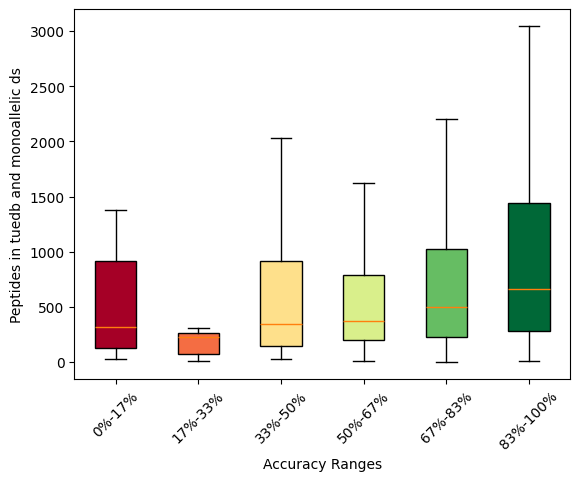

In [10]:
accuracy = []
no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    accuracy.append(plot1[donor]['matching'][0] / plot1[donor]['matching'][1])
    no_peptides.append(plot1[donor]['tdb and mono'])

num_buckets = 6
buckets = np.digitize(accuracy, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(no_peptides[i])

fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Accuracy Ranges')
plt.ylabel('Peptides in tuedb and monoallelic ds')
#plt.title('Peptides in Tuedb and Monoallelic Ds vs. Accuracy Ranges')
plt.show()

### Boxplot: Peptides in Tuedb and Monoallelic Ds vs. Accuracy Ranges (relative y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_5440\2562256266.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


The correlation is 0.27874174844295274


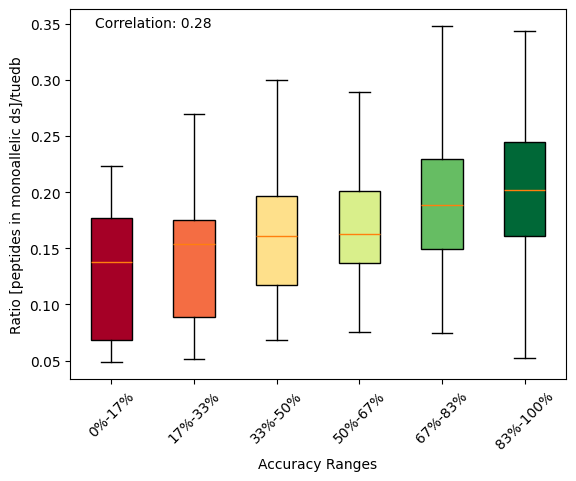

In [11]:
accuracy = []
rel_no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    accuracy.append(plot1[donor]['matching'][0] / plot1[donor]['matching'][1])
    rel_no_peptides.append(plot1[donor]['tdb and mono'] / result_dict[donor]['overall peptides in tuedb'])

num_buckets = 6
buckets = np.digitize(accuracy, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(rel_no_peptides[i])

fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

#x_ranges = ['1 of 6', '2 of 6', '3 of 6', '4 of 6', '5 of 6', '6 of 6']	
#percentages for 100
x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]	
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Accuracy Ranges')
plt.ylabel('Ratio [peptides in monoallelic ds]/tuedb')
#plt.title('Amount of Peptides in Tuedb and Accuracies')

correlation = np.corrcoef(accuracy, rel_no_peptides)[0, 1]
print('The correlation is', correlation)
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()



### Boxplot: Allele Frequency of TueDB donors vs. Accuracy Ranges (relative y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_5440\1509857259.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


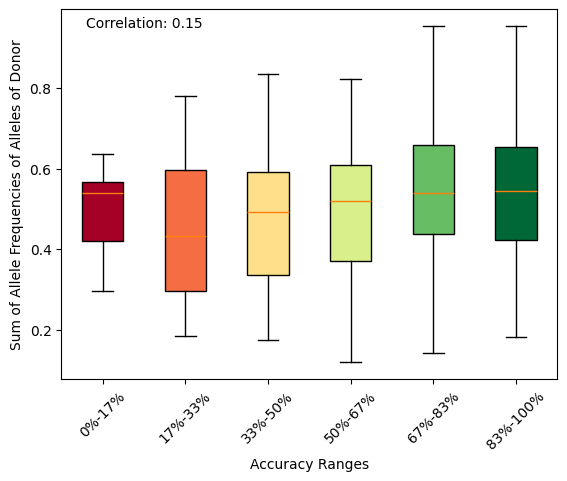

In [12]:
accuracy = []
donor_allele_frequency = []
colors = []

plot1 = plot[2]

for donor in plot1:
    accuracy.append(plot1[donor]['matching'][0] / plot1[donor]['matching'][1])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

num_buckets = 6
buckets = np.digitize(accuracy, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(donor_allele_frequency[i])

fig, ax = plt.subplots()
bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

#x_ranges = ['1 of 6', '2 of 6', '3 of 6', '4 of 6', '5 of 6', '6 of 6']
#percentages out of 100
x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]	
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Accuracy Ranges')
plt.ylabel('Sum of Allele Frequencies of Alleles of Donor')
#plt.title('Allele Frequencies and Accuracies')

correlation = np.corrcoef(accuracy, donor_allele_frequency)[0, 1]
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()

### Boxplot: Allele Frequency of TueDB donors vs. Peptides in TueDB and monoallelic dataset (absolute y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_5440\2551907664.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


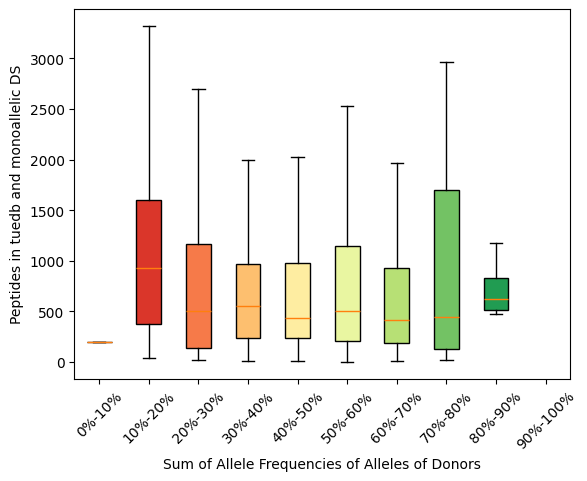

In [13]:
donor_allele_frequency = []
no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    no_peptides.append(plot1[donor]['tdb and mono'])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

num_buckets = 10
buckets = np.digitize(donor_allele_frequency, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(no_peptides[i])

# Create a boxplot for each bucket
fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]
ax.set_xticklabels(x_ranges)
#rotate x ticks
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Allele Frequencies of Donor Alleles')
plt.ylabel('Peptides in tuedb and monoallelic DS')
#plt.title('Allele Frequency and Peptides in TueDB and monoallelic DS')

# Show the plot
plt.show()

### Boxplot: Allele Frequency of TueDB donors vs. Peptides in TueDB and monoallelic dataset (relative y axis)

C:\Users\Bauers\AppData\Local\Temp\ipykernel_5440\3031723088.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


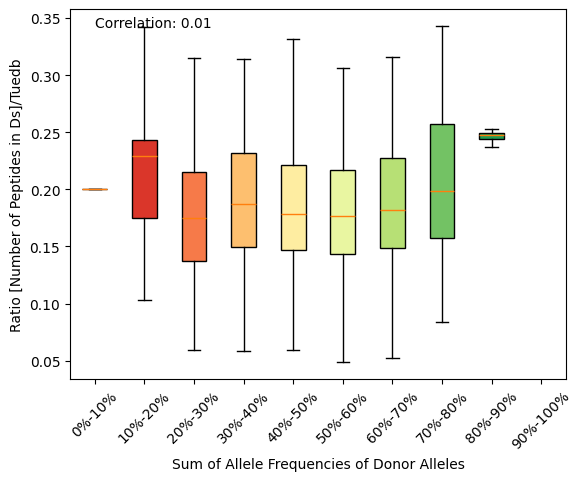

In [14]:
donor_allele_frequency = []
rel_no_peptides = []
colors = []

plot1 = plot[2]

for donor in plot1:
    rel_no_peptides.append(plot1[donor]['tdb and mono'] / result_dict[donor]['overall peptides in tuedb'])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

num_buckets = 10
buckets = np.digitize(donor_allele_frequency, np.linspace(0, 1, num_buckets))
bucket_data = {i: [] for i in range(1, num_buckets + 1)}

for i, bucket in enumerate(buckets):
    bucket_data[bucket].append(rel_no_peptides[i])

fig, ax = plt.subplots()

bp = ax.boxplot(bucket_data.values(), positions=range(1, num_buckets + 1), patch_artist=True, sym = '')
cmap = cm.get_cmap('RdYlGn')
for patch, color in zip(bp['boxes'], cmap(np.linspace(0, 1, num_buckets))):
    patch.set_facecolor(color)

x_ranges = ["{:.0f}%-{:.0f}%".format(100*(i - 1) / num_buckets, 100*i / num_buckets) for i in range(1, num_buckets + 1)]
ax.set_xticklabels(x_ranges)
plt.xticks(rotation=45)
plt.xlabel('Allele Frequencies of Donor Alleles')
plt.ylabel('Ratio [Number of Peptides in Ds]/Tuedb')
#plt.title('Accuracy Ranges vs. Sum of Allele Frequencies of Donor Alleles')

correlation = np.corrcoef(donor_allele_frequency, rel_no_peptides)[0, 1]
plt.annotate(f'Pearson R: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()

### Scatter plot: Allele Frequency of TueDB donors vs. Peptides in TueDB and monoallelic dataset (relative y axis)

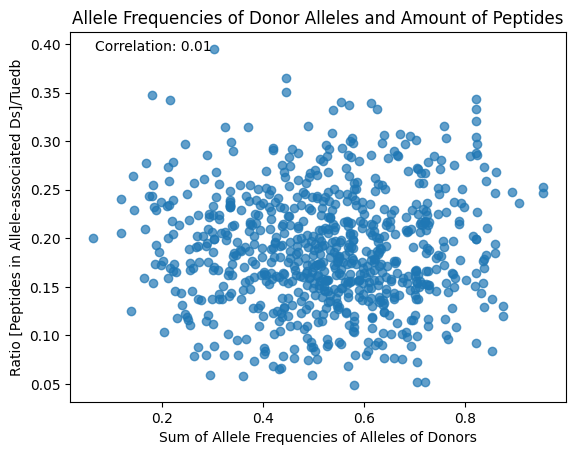

In [15]:
donor_allele_frequency = []
rel_no_peptides = []

plot1 = plot[2]

for donor in plot1:
    rel_no_peptides.append(plot1[donor]['tdb and mono'] / result_dict[donor]['overall peptides in tuedb'])
    alleles = list(result_dict[donor]['peptides']['donor allele'].keys())
    s = 0
    for a in alleles:
        a = a[0] +'*'+ a[1:3] +':'+ a[3:]
        s += allele_freq_dict[a]
    donor_allele_frequency.append(s)

fig, ax = plt.subplots()
sc = ax.scatter(donor_allele_frequency, rel_no_peptides, alpha=0.7)

plt.xlabel('Sum of Allele Frequencies of Alleles of Donors')
plt.ylabel('Ratio [Peptides in Allele-associated Ds]/Tuedb')
plt.title('Allele Frequencies of Donor Alleles and Amount of Peptides')

correlation = np.corrcoef(donor_allele_frequency, rel_no_peptides)[0, 1]
plt.annotate(f'Correlation: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', fontsize=10, color='black')
plt.show()



### Plotting all accuracies

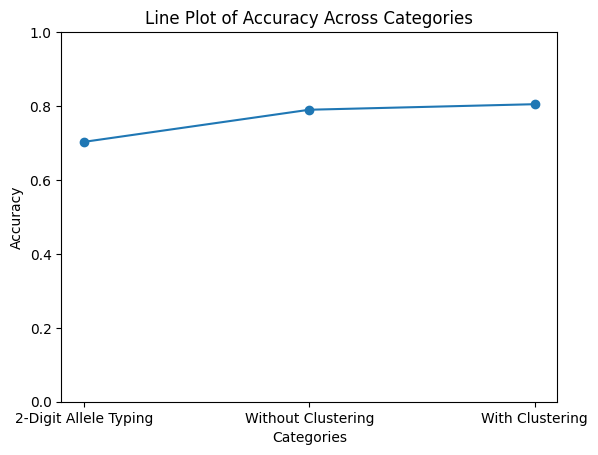

In [16]:
#first attempt: without clustering
wo_clustering = 0.790
#second attempt: with clustering
w_clustering = 0.805
#rough typing:
rough = 0.703 

# Accuracy values
approaches = ['2-Digit Allele Typing','Without Clustering', 'With Clustering']
accuracies = [rough, wo_clustering, w_clustering]

#plot the same thing with a line and dots
plt.ylim((0.0,1.0))
plt.plot(approaches, accuracies, 'o-')
plt.xlabel('Categories')
plt.ylabel('Accuracy')
plt.title('Line Plot of Accuracy Across Categories')
plt.show()


### Boxplot: Accuracies across Categories

Q1, median, Q3
[0.66666667 0.83333333 1.        ]
[0.83333333 1.         1.        ]
[0.83333333 1.         1.        ]
[0.83333333 1.         1.        ]
[1. 1. 1.]


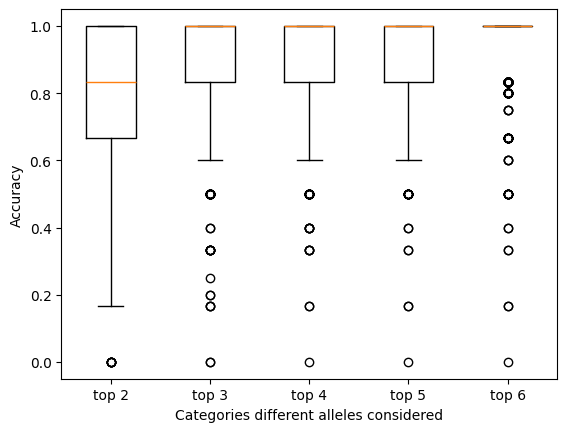

[0.8056883576803895, 0.8803231518370961, 0.9117972554227535, 0.9346170872067286, 0.9486277113767153]


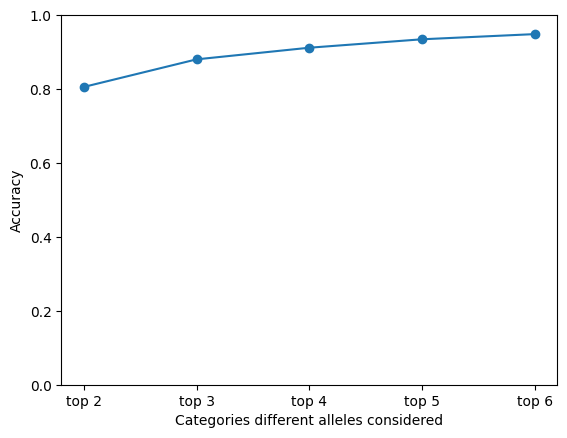

In [17]:
categories = ['top 2', 'top 3', 'top 4', 'top 5', 'top 6']

data = []

for donor in plot[2]:
    data += [[plot[2][donor]['how good'], plot[3][donor]['how good'], plot[4][donor]['how good'], plot[5][donor]['how good'],plot[6][donor]['how good']]]
transposed_data = list(zip(*data))

#print q1, median, q3
print('Q1, median, Q3')
for i in range(5):
    print(np.percentile(transposed_data[i], [25, 50, 75]))

bp = plt.boxplot(transposed_data)
plt.xticks(range(1, len(categories) + 1), categories)
plt.xlabel('Categories different alleles considered')
plt.ylabel('Accuracy')
plt.show()

transposed_data = list(zip(*data))
means = [np.mean(topx) for topx in transposed_data]
print(means)
# plot it with line with dots
#show 0 to 100 as y axis
plt.ylim((0.0,1.0))
plt.plot(categories, means, 'o-')
plt.xlabel('Categories')
plt.ylabel('Accuracy')
#plt.title('Line Plot of Accuracy Across Categories')
plt.show()


### Allele similarity of prediction and true positive allele
Load amino acid similarity matrix.

In [18]:
aas3 = ['Ser', 'Arg', 'Leu', 'Pro', 'Thr', 'Ala', 'Val', 'Gly', 'Ile', 'Phe', 'Tyr', 'Cys', 'His', 'Gln', 'Asn', 'Lys', 'Asp', 'Glu', 'Met', 'Trp']
aas =  ['S', 'R', 'L', 'P', 'T', 'A', 'V', 'G', 'I', 'F', 'Y', 'C', 'H', 'Q', 'N', 'K', 'D', 'E', 'M', 'W']

matrix_str = """
1.00 0.49 0.33 0.66 0.73 0.54 0.42 0.74 0.34 0.28 0.33 0.48 0.59 0.68 0.79 0.44 0.70 0.63 0.37 0.18
0 1.00 0.53 0.52 0.67 0.48 0.55 0.42 0.55 0.55 0.64 0.16 0.87 0.80 0.60 0.88 0.55 0.75 0.58 0.53
0 0 1.00 0.54 0.57 0.55 0.85 0.36 0.98 0.90 0.83 0.08 0.54 0.47 0.29 0.50 0.20 0.36 0.93 0.72
0 0 0 1.00 0.82 0.87 0.68 0.80 0.56 0.47 0.49 0.21 0.64 0.65 0.58 0.52 0.50 0.57 0.60 0.32
0 0 0 0 1.00 0.73 0.68 0.73 0.59 0.52 0.57 0.31 0.78 0.80 0.70 0.64 0.60 0.70 0.62 0.40
0 0 0 0 0 1.00 0.70 0.72 0.56 0.47 0.48 0.09 0.60 0.58 0.48 0.51 0.41 0.50 0.61 0.31
0 0 0 0 0 0 1.00 0.49 0.87 0.77 0.74 0.11 0.61 0.55 0.38 0.55 0.29 0.44 0.90 0.59
0 0 0 0 0 0 0 1.00 0.37 0.29 0.32 0.26 0.54 0.60 0.63 0.41 0.56 0.54 0.41 0.14
0 0 0 0 0 0 0 0 1.00 0.90 0.85 0.08 0.56 0.49 0.31 0.53 0.22 0.38 0.95 0.72
0 0 0 0 0 0 0 0 0 1.00 0.90 0.05 0.53 0.46 0.27 0.53 0.18 0.35 0.87 0.81
0 0 0 0 0 0 0 0 0 0 1.00 0.10 0.61 0.54 0.33 0.60 0.26 0.43 0.83 0.83
0 0 0 0 0 0 0 0 0 0 0 1.00 0.19 0.28 0.35 0.06 0.28 0.21 0.09 0.00
0 0 0 0 0 0 0 0 0 0 0 0 1.00 0.89 0.68 0.85 0.62 0.81 0.60 0.47
0 0 0 0 0 0 0 0 0 0 0 0 0 1.00 0.79 0.75 0.72 0.87 0.53 0.40
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.00 0.56 0.89 0.80 0.34 0.19
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.00 0.53 0.74 0.56 0.49
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.00 0.79 0.26 0.16
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.00 0.41 0.29
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.00 0.69
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.00"""

matrix = np.genfromtxt(StringIO(matrix_str), skip_header=0)


### Load MHC pseudo sequences

In [19]:
PATH_TO_MHC_PSEUDOSEQUENCES_CSV = 'MHC_pseudo.csv'

df_pseudo = pd.read_csv(PATH_TO_MHC_PSEUDOSEQUENCES_CSV, sep=' ')
sequences = df_pseudo['Pseudo-Sequence']
df_pseudo = df_pseudo[df_pseudo['Allele'].str.startswith('HLA-')]
df_pseudo['Allele'] = df_pseudo['Allele'].str[4:]
df_pseudo['Allele'] = df_pseudo['Allele'].str.replace(':','')

FileNotFoundError: [Errno 2] No such file or directory: 'MHC_pseudo.csv'

In [ ]:
def categorize_elements(lst):
    categorized = {'A': [], 'B': [], 'C': []}
    for item in lst:
        if item.startswith('A'):
            categorized['A'].append(item)
        elif item.startswith('B'):
            categorized['B'].append(item)
        elif item.startswith('C'):
            categorized['C'].append(item)
    return categorized

def make_pairs(categorized1, categorized2):
    pairs = []
    for category in categorized1:
        if len(categorized2[category]) == 2:
            pairs.append((categorized1[category][0],categorized2[category][0]))
            pairs.append((categorized1[category][1],categorized2[category][1]))
        elif len(categorized2[category]) == 1:
            pairs.append((categorized1[category][0],categorized2[category][0]))
            pairs.append((categorized1[category][0],''))
    return pairs

def give_pairs_score(pairs):
    score = 0
    for pair in pairs:
        if pair[0] == pair[1]:
            score += 1
        elif pair[0][:3] == pair[1][:3]: #same subcategory
            score += 0.3
    return score

def get_similarity(seq1: str, seq2:str) -> float:
    i1 = aas.index(seq1)
    i2 = aas.index(seq2)
    maximum = max(i1,i2)
    minimum = min(i1,i2)
    return matrix[minimum][maximum]

def get_similarity_protein(seq1: str, seq2:str) -> float:
    score = 0
    for i in range(len(seq1)):
        score += get_similarity(seq1[i],seq2[i])
    return score


In [ ]:
scores = []

similarities = {}

plot1 = plot[2]
plot1 = {k: v for k, v in plot1.items() if k != 'RCC1188'} #donor has no B1407, which has no MHC pseudo sequence
#print how many donors in plot1
print(len(plot1))
print(pairs)
count =  {'A': 0, 'B': 0, 'C': 0}
wrong = {'A': 0, 'B': 0, 'C': 0}
no_pred = {'A': 0, 'B': 0, 'C': 0}

for donor in plot1:
    categorized1 = categorize_elements(plot1[donor]['pred and real alleles'][0])
    categorized2 = categorize_elements(plot1[donor]['pred and real alleles'][1])
    try:
        pairs = make_pairs(categorized1, categorized2)
    except IndexError:
        print(donor)
        print(categorized1)
        print(categorized2)
        print(plot1[donor]['pred and real alleles'])
        break
    for pair in pairs:
        if pair[0].startswith('A'):
            count['A'] += 1
            if pair[0] != pair[1]:
                if pair[1] == '':
                    no_pred['A'] += 1
                wrong['A'] += 1
        elif pair[0].startswith('B'):
            count['B'] += 1
            if pair[0] != pair[1]:
                if pair[1] == '':
                    no_pred['B'] += 1
                wrong['B'] += 1
        elif pair[0].startswith('C'):
            count['C'] += 1
            if pair[0] != pair[1]:
                if pair[1] == '':
                    no_pred['C'] += 1
                wrong['C'] += 1
print(count)
print(wrong)
print(no_pred)

    
'''similarity = 0
    for pair in pairs:
        #calculate sequence similarity of pair
        if pair[1] == '':
            similarity += 0
        else:
            #get sequence of pair
            try:
                seq1 = str(df_pseudo[df_pseudo['Allele'] == pair[0]]['Pseudo-Sequence'].values[0])
                seq2 = str(df_pseudo[df_pseudo['Allele'] == pair[1]]['Pseudo-Sequence'].values[0])
            except IndexError:
                print(pair)
                print(donor)
                print(categorized1)
                print(categorized2)
                print(plot1[donor]['pred and real alleles'])
                break
            similarity += get_similarity_protein(seq1, seq2)
    score = similarity
    scores.append(score)
    similarities[donor] = score

scores = [scores[i]/plot1[donor]['matching'][1] for i,donor in enumerate(plot1)]

print(similarities)

print('Mean of the scores', np.round(np.mean(scores),1), 'with length of the pseudo sequences of 34 amino acids.')'''

752
[('A2601', 'A0302'), ('A0301', 'A2601'), ('B5101', 'B0801'), ('B0801', 'B5101'), ('C1502', 'C0702'), ('C0702', 'C1502')]
{'A': 1504, 'B': 1504, 'C': 1504}
{'A': 750, 'B': 760, 'C': 1066}
{'A': 109, 'B': 51, 'C': 80}


"similarity = 0\n    for pair in pairs:\n        #calculate sequence similarity of pair\n        if pair[1] == '':\n            similarity += 0\n        else:\n            #get sequence of pair\n            try:\n                seq1 = str(df_pseudo[df_pseudo['Allele'] == pair[0]]['Pseudo-Sequence'].values[0])\n                seq2 = str(df_pseudo[df_pseudo['Allele'] == pair[1]]['Pseudo-Sequence'].values[0])\n            except IndexError:\n                print(pair)\n                print(donor)\n                print(categorized1)\n                print(categorized2)\n                print(plot1[donor]['pred and real alleles'])\n                break\n            similarity += get_similarity_protein(seq1, seq2)\n    score = similarity\n    scores.append(score)\n    similarities[donor] = score\n\nscores = [scores[i]/plot1[donor]['matching'][1] for i,donor in enumerate(plot1)]\n\nprint(similarities)\n\nprint('Mean of the scores', np.round(np.mean(scores),1), 'with length of the pseudo

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


pair_to_score = {pair: score for pair, score in zip(pairs, scores)}

alleles = set()
for pair in pairs:
    alleles.update(pair)

# Initialize a 2D array for the heatmap
heatmap_data = np.zeros((len(alleles), len(alleles)))

# Fill the heatmap data with similarity scores
allele_to_index = {allele: i for i, allele in enumerate(alleles)}
for pair, score in pair_to_score.items():
    allele1, allele2 = pair
    index1, index2 = allele_to_index[allele1], allele_to_index[allele2]
    heatmap_data[index1][index2] = score
    heatmap_data[index2][index1] = score

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', xticklabels=list(alleles), yticklabels=list(alleles))
plt.xlabel('Alleles')
plt.ylabel('Alleles')
plt.title('Similarity Heatmap of Alleles')
plt.show()


ModuleNotFoundError: No module named 'seaborn'